In [2]:
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, classification_report
from collections import Counter
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn 
#Ignore annoying warning (from sklearn and seaborn)

%matplotlib inline

In [ ]:
#upload terrorism data

In [3]:
data = pd.read_csv('globalterrorismdb_0718dist.csv', encoding = "ISO-8859-1")
data = pd.DataFrame(data)

In [5]:
data.shape

(181691, 135)

181691 observations! That's a ton! However, in our other sotebook we know that our largest group still accounts for only 8% of attacks. We were warry of taking a random sample of our data, as we would likley end up missing out on a lot of terrorist groups

We also started with 135 variables! It is worth noting that we also tried converting a lot of text variables to dummies and then running PCA, however we found that in order to captrure most of the variance we still needed way more variables than our models could handel. 

### Given that an attack occurred, and someone will claim it, can we predict the correct group?

In [4]:
#get rid on unknown attacks, we can't train on things we don't know!
data = data[data.gname != 'Unknown']

In [5]:
data.shape

(98909, 135)

In [6]:
#Creating the dependent variable class
factor = pd.factorize(data['gname'])
data.gname = factor[0]
definitions = factor[1]

In [7]:
definitions[5]

'Weather Underground, Weathermen'

In [8]:
#Deal with negative integers (vicinity,nperps,nperpcap,property,ishostkid)
"""
num = data._get_numeric_data()

num[num < 0] = 'NaN'
"""

li = ['vicinity','nperps','nperpcap','property','ishostkid']
for i in li:
    data[i][data[i]<0] = np.nan

In [9]:
#Gets rid of all strings and variables directly related to our target, 'gname'
data_ = data.drop(['targsubtype1_txt', 'country_txt', 'targtype1_txt', 'natlty1_txt', 'target1', 'approxdate', 
                   'city', 'targtype2_txt', 'targsubtype2_txt', 'corp2', 'target2',
                   'natlty2_txt', 'targtype3_txt', 'targsubtype3_txt', 'corp3', 
                   'target3', 'natlty3_txt', 'weaptype1_txt', 'weapsubtype1_txt',
                   'weaptype2_txt', 'weapsubtype2_txt',
                   'region_txt', 'resolution', 'location', 'summary', 'motive', 
                   'claimmode', 'claimmode_txt', 'claim2', 'claimmode2', 'claimmode2_txt', 
                   'claim3' ,'claimmode3', 'claimmode3_txt', 'compclaim','related', 'dbsource', 
                   'scite1', 'scite2', 'scite3', 'propcomment', 'addnotes',
                   'weaptype3', 'weaptype3_txt', 'weapsubtype3' , 'weapsubtype3_txt',
                   'weaptype4', 'weaptype4_txt', 'weapsubtype4', 'weapsubtype4_txt',
                   'weapdetail' , 'propextent_txt', 'propvalue', 'propcomment',
                   'hostkidoutcome_txt', 'ransomnote', 'ransomamtus', 'ransompaid', 
                   'ransompaidus', 'gsubname', 'gname2', 'gsubname2', 'gname3', 'gsubname3',
                  'alternative_txt', 'attacktype1_txt', 'attacktype2_txt', 'attacktype3_txt', 'corp1', 'provstate',
                  'INT_LOG', 'INT_ANY', 'INT_IDEO', 'divert', 'kidhijcountry'], axis = 1)



In [35]:
data_.shape

(98909, 61)

Text(0.5,1,'Variables Correlated With Terrorist Groups')

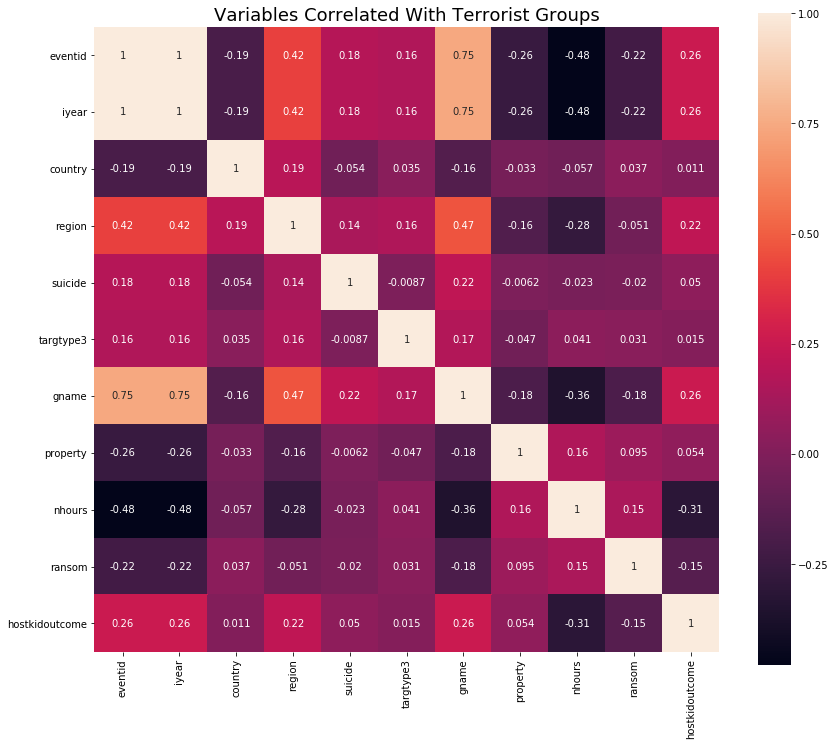

In [11]:
#Take a look at the variables that are most highly correlated with gname
corr_train = data_.corr()
highest_corr = corr_train.index[abs(corr_train['gname'])>0.15]
f, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(data[highest_corr].corr(), square = True, annot = True)
plt.title('Variables Correlated With Terrorist Groups', fontsize=18)

The heatmap isn't a great indicator, as many variables are categorical as opposed to strictly numeric.  However, this gives us an idea as to how the variances of variables may be correlated to groups.

In [11]:
corr_train.query('gname > .015').shape

(33, 61)

In [12]:
lowest_corr = corr_train.index[abs(corr_train['gname'])<=0.03]

In [13]:
lowest_corr

Index(['imonth', 'iday', 'longitude', 'specificity', 'crit1', 'crit2', 'crit3',
       'success', 'attacktype2', 'natlty1', 'natlty2', 'individual',
       'weapsubtype2', 'nkillus', 'nwound', 'nwoundus', 'nwoundte',
       'ishostkid', 'nhostkid', 'nhostkidus', 'ransomamt'],
      dtype='object')

In [13]:
#Let's drop the wort variables and see how it runs!
data__ = data_.drop(lowest_corr, 1)

In [15]:
data__.shape

(98909, 40)

In [16]:
y = data__['gname'].values
data__ = data__.drop('gname', 1)

In [17]:
data.shape

(98909, 135)

In [14]:
X = data__.fillna(0)

In [19]:
# Creating the Training and Test set from data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

### Random Forest with worst heatmap variables dropped

In [20]:
# Fitting Random Forest Classification to the Training set
classifier = RandomForestClassifier(n_estimators = 25, criterion = 'entropy', random_state = 42)
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [21]:
y_pred = classifier.predict(X_test)
print("Test Classification Report:")
print(classification_report(y_test, y_pred))

Test Classification Report:
             precision    recall  f1-score   support

          1       0.62      0.80      0.70        10
          2       0.52      0.61      0.56        18
          3       1.00      1.00      1.00         7
          5       0.27      0.50      0.35         6
          6       0.70      0.90      0.79        39
          7       1.00      0.67      0.80         3
          9       1.00      1.00      1.00         1
         10       0.86      0.75      0.80         8
         11       0.55      0.50      0.52        12
         12       0.62      0.36      0.46        22
         13       0.00      0.00      0.00         0
         14       0.81      0.94      0.87       518
         15       0.67      0.67      0.67         9
         16       0.14      0.11      0.12        28
         18       0.00      0.00      0.00         1
         19       0.00      0.00      0.00         8
         20       0.67      0.80      0.73         5
         21      

#### Avg f1 score of .75!

Not bad!

Now, lets see how that differs from using all available variables:

### RF with all variables

In [8]:
data_own = data_.fillna(0)
y = data_own['gname'].values
data_own = data_own.drop('gname', 1)

In [9]:
X = data_own

In [10]:
# Creating the Training and Test set from data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 41)

In [11]:
# Fitting Random Forest Classification to the Training set
classifier = RandomForestClassifier(n_estimators = 25, criterion = 'entropy', random_state = 42)
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [22]:
y_pred = classifier.predict(X_test)
print("Test Classification Report:")
print(classification_report(y_test, y_pred))

Test Classification Report:
             precision    recall  f1-score   support

          1       0.60      1.00      0.75         6
          2       0.46      0.33      0.39        18
          3       1.00      1.00      1.00        15
          4       1.00      0.50      0.67         2
          5       0.57      0.40      0.47        10
          6       0.52      0.83      0.64        29
          7       1.00      0.60      0.75         5
          8       0.00      0.00      0.00         1
          9       0.55      1.00      0.71         6
         10       0.79      0.85      0.81        13
         11       0.47      0.54      0.50        13
         12       0.52      0.50      0.51        28
         14       0.86      0.98      0.92       557
         15       0.86      0.86      0.86         7
         16       0.29      0.17      0.21        36
         17       0.00      0.00      0.00         3
         18       0.00      0.00      0.00         2
         19      

#### avg f1 of .76!

It did a little better! But which variables were most important?

In [12]:
names = list(X)
feature_imp = sorted(list(zip( names , classifier.feature_importances_)), key=lambda x: x[1], reverse=True)

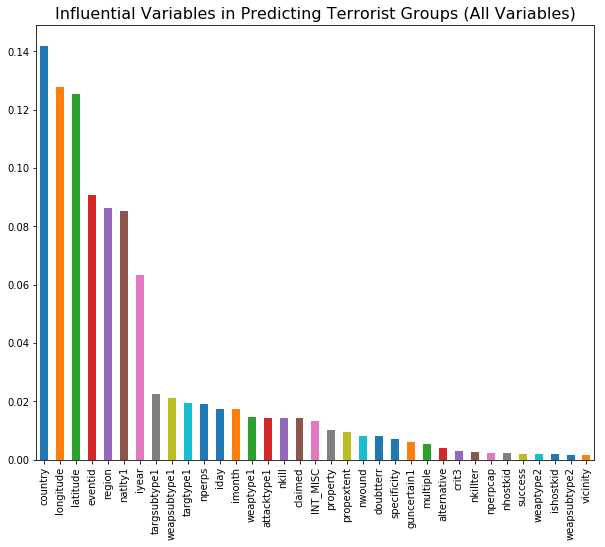

In [20]:
f, ax = plt.subplots(figsize=(10, 8))
plt.title('Influential Variables in Predicting Terrorist Groups (All Variables)', fontsize=16)
pd.Series([x[1] for x in feature_imp[:35]], index=[x[0] for x in feature_imp[:35]]).plot(kind='bar')

In [28]:
feature_imp[30:]

[('success', 0.002033847044994073),
 ('weaptype2', 0.0020139573981671835),
 ('ishostkid', 0.0020062575014238404),
 ('weapsubtype2', 0.0016747106449232785),
 ('vicinity', 0.001511090578996832),
 ('hostkidoutcome', 0.001480582325728232),
 ('suicide', 0.001320047611322745),
 ('natlty2', 0.001181013757338745),
 ('extended', 0.0010883631478305672),
 ('targtype2', 0.0010660648191966387),
 ('ndays', 0.0010193120600239865),
 ('targsubtype2', 0.0009871505835091633),
 ('nreleased', 0.0009859276868322555),
 ('attacktype2', 0.0008906527408181587),
 ('ransom', 0.00041322048754347017),
 ('individual', 0.0003715448779015371),
 ('crit2', 0.00033538950223699603),
 ('nhours', 0.00032579633602271713),
 ('nwoundte', 0.00023233472119615496),
 ('guncertain2', 0.0002291525926115259),
 ('ransomamt', 0.00020636430219887398),
 ('nkillus', 0.00017670273522437483),
 ('crit1', 0.00015270105123596733),
 ('nwoundus', 0.00015028510365372674),
 ('natlty3', 0.00010073421587221046),
 ('targtype3', 9.890903607299534e-05)

Let's get rid of the worst variables in our training set, and try again!

In [11]:
Q = X.drop(['guncertain3','attacktype3', 'targsubtype3',
           'nhostkidus', 'targtype3', 'natlty3', 'nwoundus',
           'crit1', 'nkillus', 'ransomamt', 'guncertain2', 
           'nwoundte', 'nhours', 'crit2', 'individual', 'ransom',
           'attacktype2', 'extended', 'nreleased', 'targsubtype2',
           'targtype2', 'ndays', 'natlty2', 'suicide', 'hostkidoutcome',
           'vicinity', 'weapsubtype2', 'ishostkid', 'weaptype2', 'success'], 1)

In [12]:
# Creating the Training and Test set from data
X_train, X_test, y_train, y_test = train_test_split(Q, y, test_size = 0.2, random_state = 41)

### RF with worst RF variables dropped

In [104]:
# Fitting Random Forest Classification to the Training set
classifier = RandomForestClassifier(n_estimators = 25, criterion = 'entropy', random_state = 42)
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [105]:
y_pred = classifier.predict(X_test)
print("Test Classification Report:")
print(classification_report(y_test, y_pred))

Test Classification Report:
             precision    recall  f1-score   support

          1       0.55      1.00      0.71         6
          2       0.53      0.44      0.48        18
          3       1.00      1.00      1.00        15
          4       1.00      0.50      0.67         2
          5       0.33      0.30      0.32        10
          6       0.59      0.83      0.69        29
          7       1.00      0.60      0.75         5
          8       0.00      0.00      0.00         1
          9       0.50      1.00      0.67         6
         10       0.85      0.85      0.85        13
         11       0.64      0.69      0.67        13
         12       0.58      0.54      0.56        28
         14       0.89      0.99      0.94       557
         15       0.86      0.86      0.86         7
         16       0.35      0.19      0.25        36
         17       0.00      0.00      0.00         3
         18       0.00      0.00      0.00         2
         19      

#### F1 score of .78!!

That's the best so far! Now, we'll do some hyperparameter tuning to see if we can beat it...

### Gini RF

In [13]:
# Fitting Random Forest Classification to the Training set
classifier = RandomForestClassifier(n_estimators = 25, criterion = 'gini', random_state = 42)
classifier.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [14]:
y_pred = classifier.predict(X_test)
print("Test Classification Report:")
print(classification_report(y_test, y_pred))

Test Classification Report:
             precision    recall  f1-score   support

          1       0.55      1.00      0.71         6
          2       0.47      0.39      0.42        18
          3       1.00      1.00      1.00        15
          4       1.00      0.50      0.67         2
          5       0.38      0.30      0.33        10
          6       0.55      0.79      0.65        29
          7       1.00      1.00      1.00         5
          8       0.00      0.00      0.00         1
          9       0.60      1.00      0.75         6
         10       0.83      0.77      0.80        13
         11       0.55      0.46      0.50        13
         12       0.60      0.54      0.57        28
         14       0.89      0.98      0.94       557
         15       0.86      0.86      0.86         7
         16       0.25      0.17      0.20        36
         17       0.00      0.00      0.00         3
         18       0.00      0.00      0.00         2
         19      

#### Increase min_samples_leaf :

In [24]:
# Fitting Random Forest Classification to the Training set
classifier = RandomForestClassifier(n_estimators = 25, criterion = 'entropy', min_samples_leaf = 2, random_state = 42)
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [25]:
y_pred = classifier.predict(X_test)
print("Test Classification Report:")
print(classification_report(y_test, y_pred))

Test Classification Report:
             precision    recall  f1-score   support

          1       0.55      1.00      0.71         6
          2       0.42      0.28      0.33        18
          3       1.00      1.00      1.00        15
          4       0.00      0.00      0.00         2
          5       0.50      0.30      0.37        10
          6       0.57      0.97      0.72        29
          7       0.80      0.80      0.80         5
          8       0.00      0.00      0.00         1
          9       0.60      1.00      0.75         6
         10       0.91      0.77      0.83        13
         11       0.67      0.62      0.64        13
         12       0.60      0.54      0.57        28
         14       0.88      0.98      0.93       557
         15       1.00      0.86      0.92         7
         16       0.32      0.17      0.22        36
         17       0.00      0.00      0.00         3
         18       0.00      0.00      0.00         2
         19      

#### Increase n

In [13]:
# Fitting Random Forest Classification to the Training set
classifier = RandomForestClassifier(n_estimators = 35, criterion = 'entropy', min_samples_leaf = 2, random_state = 42)
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=35, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [14]:
y_pred = classifier.predict(X_test)
print("Test Classification Report:")
print(classification_report(y_test, y_pred))

Test Classification Report:
             precision    recall  f1-score   support

          1       0.60      1.00      0.75         6
          2       0.43      0.33      0.38        18
          3       1.00      1.00      1.00        15
          4       0.00      0.00      0.00         2
          5       0.43      0.30      0.35        10
          6       0.58      0.97      0.73        29
          7       0.80      0.80      0.80         5
          8       0.00      0.00      0.00         1
          9       0.60      1.00      0.75         6
         10       0.91      0.77      0.83        13
         11       0.70      0.54      0.61        13
         12       0.59      0.61      0.60        28
         14       0.87      0.98      0.93       557
         15       1.00      0.86      0.92         7
         16       0.40      0.17      0.24        36
         17       0.00      0.00      0.00         3
         18       0.00      0.00      0.00         2
         19      

Nothing beat our original, unrestricted tree with 25 trees! Good to note.

Below, we tried a Grid Search and it ran poorly and took a very long time... that's why we did a lot of the tuning above by hand.

In [23]:
param_dist = {"n_estimators": [25], "max_depth": [10], "bootstrap": ['True'], "max_leaf_nodes": [25], "min_samples_split": [2], "max_features": [10], "min_impurity_decrease": [.1, .2]}

#, "max_depth": [1, 5, 10,], "bootstrap": ['True'], "max_leaf_nodes": [10, 25], "min_samples_split": [2, 5, 10], "max_features": [10], "min_impurity_decrease": [.1, .2, .5], 
#Again, testing different hyperparameters. We will be testing different amounts of depths, impurities (similar to the cost function),
#features, and nodes.
rfregressor = RandomForestClassifier(criterion = 'entropy')
rfgridsearch = GridSearchCV(rfregressor, param_grid=param_dist, n_jobs=-1)
rfgridsearch.fit(X_train,y_train)
best_params=rfgridsearch.best_params_


In [15]:
print(best_params)

{'bootstrap': 'True', 'max_depth': 10, 'max_features': 10, 'max_leaf_nodes': 25, 'min_impurity_decrease': 0.1, 'min_samples_split': 2, 'n_estimators': 25}


In [17]:
rf1reg = RandomForestClassifier(n_estimators = best_params['n_estimators'], max_depth = best_params['max_depth'], min_samples_split= best_params['min_samples_split'],
                              max_features= best_params['max_features'], min_impurity_decrease = best_params['min_impurity_decrease'],
                              max_leaf_nodes = best_params['max_leaf_nodes'], bootstrap = best_params['bootstrap'], n_jobs=-1)

In [19]:
rf1reg.fit(X_train, y_train)
#train_predictions = rf1reg.predict(X_train)
test_predictions = rf1reg.predict(X_test)
print("Test Classification Report:")
print(classification_report(y_test, test_predictions))
#print(classification_report(y_test, y_pred))

Test Classification Report:
             precision    recall  f1-score   support

          1       0.00      0.00      0.00         6
          2       0.00      0.00      0.00        18
          3       0.00      0.00      0.00        15
          4       0.00      0.00      0.00         2
          5       0.00      0.00      0.00        10
          6       0.00      0.00      0.00        29
          7       0.00      0.00      0.00         5
          8       0.00      0.00      0.00         1
          9       0.00      0.00      0.00         6
         10       0.00      0.00      0.00        13
         11       0.00      0.00      0.00        13
         12       0.00      0.00      0.00        28
         14       0.00      0.00      0.00       557
         15       0.00      0.00      0.00         7
         16       0.00      0.00      0.00        36
         17       0.00      0.00      0.00         3
         18       0.00      0.00      0.00         2
         19      

### How does elastic net do?

In [26]:
#Elastic Net
from sklearn.linear_model import ElasticNet, Lasso, SGDClassifier

In [27]:
eln = SGDClassifier(loss="log", penalty="elasticnet")

In [32]:
eln.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=1, penalty='elasticnet', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [33]:
y_pred = eln.predict(X_test)
print("Test Classification Report:")
print(classification_report(y_test, test_predictions))

Test Classification Report:
             precision    recall  f1-score   support

          1       0.00      0.00      0.00         6
          2       0.00      0.00      0.00        18
          3       0.00      0.00      0.00        15
          4       0.00      0.00      0.00         2
          5       0.00      0.00      0.00        10
          6       0.00      0.00      0.00        29
          7       0.00      0.00      0.00         5
          8       0.00      0.00      0.00         1
          9       0.00      0.00      0.00         6
         10       0.00      0.00      0.00        13
         11       0.00      0.00      0.00        13
         12       0.00      0.00      0.00        28
         14       0.00      0.00      0.00       557
         15       0.00      0.00      0.00         7
         16       0.00      0.00      0.00        36
         17       0.00      0.00      0.00         3
         18       0.00      0.00      0.00         2
         19      

Random Forest obviously does significantly better...

This isn't suprisng, as a gain a lot of our variables are categorical! Elastic net can't handle that well. Again, when we tried to make those variables dummies it was still far too many for our regressions to handel.

### We tried Boosting, but it took tooooooo long

In [34]:

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, classification_report
from collections import Counter
import numpy as np
import pandas as pd
%matplotlib inline

In [98]:
clf = GradientBoostingClassifier()
#gridsearch = GridSearchCV(clf, {"learning_rate": [.1, .01], "n_estimators": [100], 
#                                'max_depth': [2]}, scoring='f1', n_jobs=-1)
#gridsearch.fit(X_train, y_train)
clf.fit(X_train, y_train)

KeyboardInterrupt: 

How well can we predict whether someoene will even take responsibility for a terrorist attack?

### Unknown vs. Known

In [22]:
data = pd.read_csv('globalterrorismdb_0718dist.csv', encoding = "ISO-8859-1")
data = pd.DataFrame(data)

In [23]:
#data['unknown'] = data.query('gname == Unknown')*1
data['unk'] = data['gname'] == 'Unknown'

In [24]:
data['unk'] = data['unk']*1

In [25]:
#Gets rid of all strings and related variables
data = data.drop(['targsubtype1_txt', 'country_txt', 'targtype1_txt', 'natlty1_txt', 'target1', 'approxdate', 
                   'city', 'targtype2_txt', 'targsubtype2_txt', 'corp2', 'target2',
                   'natlty2_txt', 'targtype3_txt', 'targsubtype3_txt', 'corp3', 
                   'target3', 'natlty3_txt', 'weaptype1_txt', 'weapsubtype1_txt',
                   'weaptype2_txt', 'weapsubtype2_txt',
                   'region_txt', 'resolution', 'location', 'summary', 'motive', 
                   'claimmode', 'claimmode_txt', 'claim2', 'claimmode2', 'claimmode2_txt', 
                   'claim3' ,'claimmode3', 'claimmode3_txt', 'compclaim','related', 'dbsource', 
                   'scite1', 'scite2', 'scite3', 'propcomment', 'addnotes',
                   'weaptype3', 'weaptype3_txt', 'weapsubtype3' , 'weapsubtype3_txt',
                   'weaptype4', 'weaptype4_txt', 'weapsubtype4', 'weapsubtype4_txt',
                   'weapdetail' , 'propextent_txt', 'propvalue', 'propcomment',
                   'hostkidoutcome_txt', 'ransomnote', 'ransomamtus', 'ransompaid', 
                   'ransompaidus', 'gsubname', 'gname2', 'gsubname2', 'gname3', 'gsubname3',
                  'alternative_txt', 'attacktype1_txt', 'attacktype2_txt', 'attacktype3_txt', 'corp1', 'provstate',
                  'INT_LOG', 'INT_ANY', 'INT_IDEO', 'divert', 'kidhijcountry', 'gname', 'claimed'], axis = 1)

In [26]:
data_unk = data.fillna(0)
y = data_unk['unk'].values
data_unk = data_unk.drop('unk', 1)

In [27]:
X = data_unk
# Creating the Training and Test set from data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 41)

In [28]:
# Fitting Random Forest Classification to the Training set
classifier = RandomForestClassifier(n_estimators = 20, criterion = 'entropy', random_state = 42)
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [29]:
y_pred = classifier.predict(X_test)
print("Test Classification Report:")
print(classification_report(y_test, y_pred))

Test Classification Report:
             precision    recall  f1-score   support

          0       0.86      0.88      0.87     19693
          1       0.86      0.83      0.85     16646

avg / total       0.86      0.86      0.86     36339



In [30]:
names = list(X)
feature_imp = sorted(list(zip( names , classifier.feature_importances_)), key=lambda x: x[1], reverse=True)

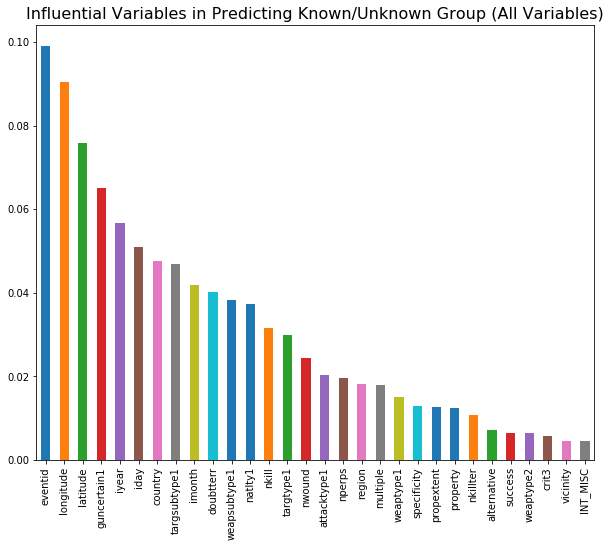

In [32]:
f, ax = plt.subplots(figsize=(10, 8))
plt.title('Influential Variables in Predicting Known/Unknown Group (All Variables)', fontsize=16)
pd.Series([x[1] for x in feature_imp[:30]], index=[x[0] for x in feature_imp[:30]]).plot(kind='bar')

In [15]:
from sklearn.datasets import make_classification
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
import numpy as np
%matplotlib inline

### SVM

We also tried SVM but it also took tooooooo long 

In [ ]:
clf = SVC()
#gridsearch = GridSearchCV(clf, {"C": [0.05, 0.1, 0.15], "kernel": ['rbf'], 'gamma': [0.5, 1, 1.5]}, scoring='accuracy')
clf.fit(X_train, y_train)
print("Best Params: {}".format(gridsearch.best_params_))
print("Test Accuracy: {}".format(accuracy_score(y_test, gridsearch.predict(X_test))))

### Feature Engineering

In [81]:
from sklearn import preprocessing
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, classification_report
from collections import Counter
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn 
#Ignore annoying warning (from sklearn and seaborn)

%matplotlib inline

In [82]:
data = pd.read_csv('globalterrorismdb_0718dist.csv', encoding = "ISO-8859-1")
data = pd.DataFrame(data)

In [83]:
#get rid on unknown attacks
data = data[data.gname != 'Unknown']

In [84]:
#Creating the dependent variable class
factor = pd.factorize(data['gname'])
data.gname = factor[0]
definitions = factor[1]

In [85]:
#Gets rid of all strings and related variables
data_ = data.drop(['targsubtype1_txt', 'country_txt', 'targtype1_txt', 'natlty1_txt', 'target1', 'approxdate', 
                   'city', 'targtype2_txt', 'targsubtype2_txt', 'corp2', 'target2',
                   'natlty2_txt', 'targtype3_txt', 'targsubtype3_txt', 'corp3', 
                   'target3', 'natlty3_txt', 'weaptype1_txt', 'weapsubtype1_txt',
                   'weaptype2_txt', 'weapsubtype2_txt',
                   'region_txt', 'resolution', 'location', 'summary', 'motive', 
                   'claimmode', 'claimmode_txt', 'claim2', 'claimmode2', 'claimmode2_txt', 
                   'claim3' ,'claimmode3', 'claimmode3_txt', 'compclaim','related', 'dbsource', 
                   'scite1', 'scite2', 'scite3', 'propcomment', 'addnotes',
                   'weaptype3', 'weaptype3_txt', 'weapsubtype3' , 'weapsubtype3_txt',
                   'weaptype4', 'weaptype4_txt', 'weapsubtype4', 'weapsubtype4_txt',
                   'weapdetail' , 'propextent_txt', 'propvalue', 'propcomment',
                   'hostkidoutcome_txt', 'ransomnote', 'ransomamtus', 'ransompaid', 
                   'ransompaidus', 'gsubname', 'gname2', 'gsubname2', 'gname3', 'gsubname3',
                  'alternative_txt', 'attacktype1_txt', 'attacktype2_txt', 'attacktype3_txt', 'corp1', 'provstate',
                  'INT_LOG', 'INT_ANY', 'INT_IDEO', 'divert', 'kidhijcountry'], axis = 1)




In [86]:
data_ = data_.fillna(0)
y = data_['gname'].values
data_ = data_.drop('gname', 1)

In [87]:
data_['devastation'] = data_['nkill'] + data_['nkillter'] + data_['nwound']

In [88]:
data_['devastation+'] = data_['propextent'] + data_['devastation']/10000

In [89]:
data_['devastation+'].describe()

count    98909.000000
mean         1.182232
std          1.619783
min          0.000000
25%          0.000100
50%          0.000500
75%          3.000000
max          4.123400
Name: devastation+, dtype: float64

In [90]:
#data_['percuswound'] = data_['nwoundus']/(data_['nwound']+.000001)

In [91]:
#data_['percuskill'] = data_['nkillus']/(data_['nkill'] + .000001)

In [92]:
data_['countryweapon'] = data_['country'] + (data_['weapsubtype1']/100)

In [93]:
data_['countrydevastation+'] = data_['country'] + data_['devastation+']/10

In [94]:
data_['countryyear'] = data_['country']+(data_['iyear']-1950)/100

In [95]:
y

array([   0,    1,    2, ..., 2698,  597, 2975])

In [27]:
X = data_

# Creating the Training and Test set from data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 41)

# Fitting Random Forest Classification to the Training set
classifier = RandomForestClassifier(n_estimators = 25, criterion = 'entropy', random_state = 42)
classifier.fit(X_train, y_train)



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [28]:
y_pred = classifier.predict(X_test)
print("Test Classification Report:")
print(classification_report(y_test, y_pred))

Test Classification Report:
             precision    recall  f1-score   support

          1       0.60      1.00      0.75         6
          2       0.53      0.44      0.48        18
          3       1.00      1.00      1.00        15
          4       0.00      0.00      0.00         2
          5       0.33      0.40      0.36        10
          6       0.60      0.90      0.72        29
          7       0.80      0.80      0.80         5
          8       0.00      0.00      0.00         1
          9       0.56      0.83      0.67         6
         10       0.86      0.92      0.89        13
         11       0.64      0.69      0.67        13
         12       0.56      0.50      0.53        28
         14       0.88      0.98      0.93       557
         15       1.00      0.86      0.92         7
         16       0.40      0.22      0.29        36
         17       0.00      0.00      0.00         3
         18       0.00      0.00      0.00         2
         19      

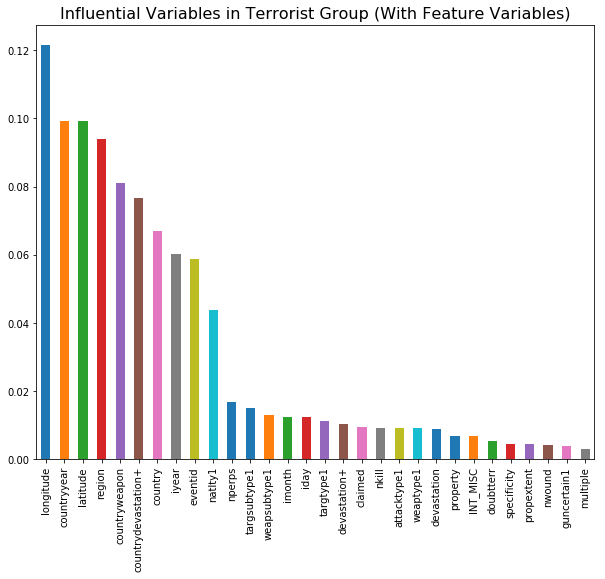

In [18]:
names = list(X)
feature_imp = sorted(list(zip( names , classifier.feature_importances_)), key=lambda x: x[1], reverse=True)

f, ax = plt.subplots(figsize=(10, 8))
plt.title('Influential Variables in Terrorist Group (With Feature Variables)', fontsize=16)
pd.Series([x[1] for x in feature_imp[:30]], index=[x[0] for x in feature_imp[:30]]).plot(kind='bar')

In [21]:
feature_imp[35:]

[('crit3', 0.0012027589060321902),
 ('ishostkid', 0.0011953557359298493),
 ('hostkidoutcome', 0.001174754424591269),
 ('nkillter', 0.0010963892730824),
 ('weapsubtype2', 0.0010752792825679998),
 ('vicinity', 0.0009949931846138266),
 ('nreleased', 0.000713719134189768),
 ('ndays', 0.0007124013938311486),
 ('targsubtype2', 0.0006860761205937367),
 ('targtype2', 0.0006568083274644674),
 ('extended', 0.0006247356812422844),
 ('natlty2', 0.000552826769218571),
 ('suicide', 0.0005404602002686941),
 ('attacktype2', 0.0004177499043136209),
 ('ransom', 0.0002971684149798362),
 ('individual', 0.00026937913925683695),
 ('crit2', 0.00024640045212506647),
 ('nhours', 0.00022437122156219154),
 ('guncertain2', 0.0001966649625665195),
 ('ransomamt', 0.0001687219331215322),
 ('nwoundte', 0.00015615132229656584),
 ('crit1', 0.0001407063455166626),
 ('nwoundus', 0.00010244266600442891),
 ('targtype3', 8.126450708254898e-05),
 ('nkillus', 7.986151137972913e-05),
 ('natlty3', 6.298733136729204e-05),
 ('tar

In [96]:
Q = X.drop(['guncertain3','attacktype3', 'targsubtype3',
           'nhostkidus', 'targtype3', 'natlty3', 'nwoundus',
           'crit1', 'nkillus', 'ransomamt', 'guncertain2', 
           'nwoundte', 'nhours', 'crit2', 'individual', 'ransom',
           'attacktype2', 'extended', 'nreleased', 'targsubtype2',
           'targtype2', 'ndays', 'natlty2', 'suicide', 'hostkidoutcome',
           'vicinity', 'weapsubtype2', 'ishostkid', 'weaptype2', 'success',
           'nhours', 'nreleased'], 1)

In [97]:

# Creating the Training and Test set from data
X_train, X_test, y_train, y_test = train_test_split(Q, y, test_size = 0.2, random_state = 41)

# Fitting Random Forest Classification to the Training set
classifier = RandomForestClassifier(n_estimators = 25, criterion = 'entropy', random_state = 42)
classifier.fit(X_train, y_train)




RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [21]:
y_pred = classifier.predict(X_test)
print("Test Classification Report:")
print(classification_report(y_test, y_pred))

Test Classification Report:
             precision    recall  f1-score   support

          1       0.50      1.00      0.67         6
          2       0.58      0.39      0.47        18
          3       1.00      1.00      1.00        15
          4       0.00      0.00      0.00         2
          5       0.27      0.30      0.29        10
          6       0.62      0.90      0.73        29
          7       1.00      1.00      1.00         5
          8       0.00      0.00      0.00         1
          9       0.75      1.00      0.86         6
         10       0.83      0.77      0.80        13
         11       0.62      0.62      0.62        13
         12       0.57      0.46      0.51        28
         14       0.90      0.98      0.94       557
         15       1.00      0.86      0.92         7
         16       0.33      0.19      0.25        36
         17       0.00      0.00      0.00         3
         18       0.00      0.00      0.00         2
         19      

We note that this model with feature engineering did exactly as well as our previous best model!

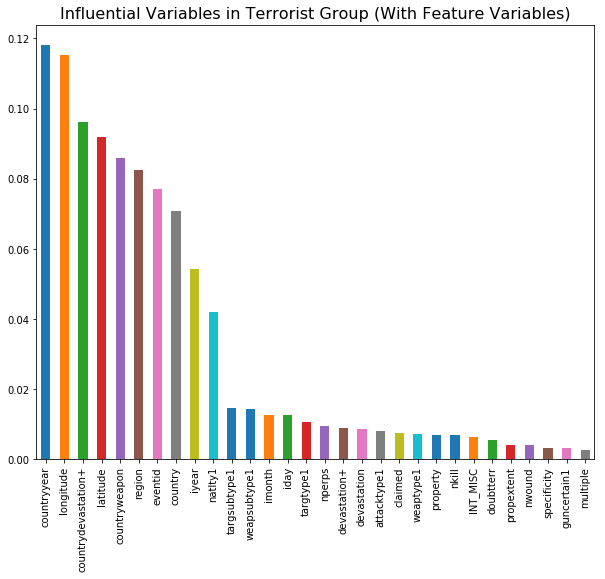

In [22]:
names = list(Q)
feature_imp = sorted(list(zip( names , classifier.feature_importances_)), key=lambda x: x[1], reverse=True)

f, ax = plt.subplots(figsize=(10, 8))
plt.title('Influential Variables in Terrorist Group (With Feature Variables)', fontsize=16)
pd.Series([x[1] for x in feature_imp[:30]], index=[x[0] for x in feature_imp[:30]]).plot(kind='bar')

### What heppens when we predict unknown observations?

In [99]:
data = pd.read_csv('globalterrorismdb_0718dist.csv', encoding = "ISO-8859-1")
data = pd.DataFrame(data)


In [100]:
dataunkn = data[data.gname == 'Unknown']

In [127]:
trial = dataunkn.sample(1)

In [128]:
trial = trial.drop(['targsubtype1_txt', 'country_txt', 'targtype1_txt', 'natlty1_txt', 'target1', 'approxdate', 
                   'city', 'targtype2_txt', 'targsubtype2_txt', 'corp2', 'target2',
                   'natlty2_txt', 'targtype3_txt', 'targsubtype3_txt', 'corp3', 
                   'target3', 'natlty3_txt', 'weaptype1_txt', 'weapsubtype1_txt',
                   'weaptype2_txt', 'weapsubtype2_txt',
                   'region_txt', 'resolution', 'location', 'summary', 'motive', 
                   'claimmode', 'claimmode_txt', 'claim2', 'claimmode2', 'claimmode2_txt', 
                   'claim3' ,'claimmode3', 'claimmode3_txt', 'compclaim','related', 'dbsource', 
                   'scite1', 'scite2', 'scite3', 'propcomment', 'addnotes',
                   'weaptype3', 'weaptype3_txt', 'weapsubtype3' , 'weapsubtype3_txt',
                   'weaptype4', 'weaptype4_txt', 'weapsubtype4', 'weapsubtype4_txt',
                   'weapdetail' , 'propextent_txt', 'propvalue', 'propcomment',
                   'hostkidoutcome_txt', 'ransomnote', 'ransomamtus', 'ransompaid', 
                   'ransompaidus', 'gsubname', 'gname2', 'gsubname2', 'gname3', 'gsubname3',
                  'alternative_txt', 'attacktype1_txt', 'attacktype2_txt', 'attacktype3_txt', 'corp1', 'provstate',
                  'INT_LOG', 'INT_ANY', 'INT_IDEO', 'divert', 'kidhijcountry',
                   'guncertain3','attacktype3', 'targsubtype3',           'nhostkidus', 'targtype3', 'natlty3', 'nwoundus',
           'crit1', 'nkillus', 'ransomamt', 'guncertain2', 
           'nwoundte', 'nhours', 'crit2', 'individual', 'ransom',
           'attacktype2', 'extended', 'nreleased', 'targsubtype2',
           'targtype2', 'ndays', 'natlty2', 'suicide', 'hostkidoutcome',
           'vicinity', 'weapsubtype2', 'ishostkid', 'weaptype2', 'success',
           'nhours', 'nreleased', 'gname'], axis = 1)

trial['devastation'] = trial['nkill'] + trial['nkillter'] + trial['nwound']
trial['devastation+'] = trial['propextent'] + trial['devastation']/10000
trial['countryweapon'] = trial['country'] + (trial['weapsubtype1']/100)
trial['countrydevastation+'] = trial['country'] + trial['devastation+']/10
trial['countryyear'] = trial['country']+(trial['iyear']-1950)/100

trial = trial.fillna(0)



In [129]:
y_pred = classifier.predict(trial)

In [130]:
trial.describe()

,eventid,iyear,imonth,iday,country,region,latitude,longitude,specificity,crit3,doubtterr,alternative,multiple,attacktype1,targtype1,targsubtype1,natlty1,guncertain1,nperps,nperpcap,claimed,weaptype1,weapsubtype1,nkill,nkillter,nwound,property,propextent,nhostkid,INT_MISC,devastation,devastation+,countryweapon,countrydevastation+,countryyear
count,1.000000e+00,1.0,1.0,1.0,1.0,1.0,1.000000,1.00000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.00,1.0,1.00
mean,1.995073e+11,1995.0,7.0,25.0,87.0,2.0,18.527716,-72.33284,1.0,1.0,-9.0,0.0,0.0,1.0,1.0,0.0,87.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,87.05,0.0,87.45
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.995073e+11,1995.0,7.0,25.0,87.0,2.0,18.527716,-72.33284,1.0,1.0,-9.0,0.0,0.0,1.0,1.0,0.0,87.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,87.05,0.0,87.45
25%,1.995073e+11,1995.0,7.0,25.0,87.0,2.0,18.527716,-72.33284,1.0,1.0,-9.0,0.0,0.0,1.0,1.0,0.0,87.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,87.05,0.0,87.45
50%,1.995073e+11,1995.0,7.0,25.0,87.0,2.0,18.527716,-72.33284,1.0,1.0,-9.0,0.0,0.0,1.0,1.0,0.0,87.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,87.05,0.0,87.45
75%,1.995073e+11,1995.0,7.0,25.0,87.0,2.0,18.527716,-72.33284,1.0,1.0,-9.0,0.0,0.0,1.0,1.0,0.0,87.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,87.05,0.0,87.45
max,1.995073e+11,1995.0,7.0,25.0,87.0,2.0,18.527716,-72.33284,1.0,1.0,-9.0,0.0,0.0,1.0,1.0,0.0,87.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,87.05,0.0,87.45


In [131]:
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

In [132]:
trial['prediction'] = definitions[y_pred]

In [133]:
trial

,eventid,iyear,imonth,iday,country,region,latitude,longitude,specificity,crit3,doubtterr,alternative,multiple,attacktype1,targtype1,targsubtype1,natlty1,guncertain1,nperps,nperpcap,claimed,weaptype1,weapsubtype1,nkill,nkillter,nwound,property,propextent,nhostkid,INT_MISC,devastation,devastation+,countryweapon,countrydevastation+,countryyear,prediction
59927,199507250015,1995,7,25,87,2,18.527716,-72.33284,1.0,1,-9.0,0.0,0.0,1,1,0.0,87.0,0.0,0.0,0.0,0.0,5,5.0,0.0,0.0,1.0,0,0.0,0.0,0,0.0,0.0,87.05,0.0,87.45,Guatemalan National Revolutionary Unity (URNG)


In [122]:
trial2 = trial

In [145]:
trials = trials.append(trial)

In [144]:
trials= trials[:2]

### Table of predicted unknowns:


In [146]:
trials

,eventid,iyear,imonth,iday,country,region,latitude,longitude,specificity,crit3,doubtterr,alternative,multiple,attacktype1,targtype1,targsubtype1,natlty1,guncertain1,nperps,nperpcap,claimed,weaptype1,weapsubtype1,nkill,nkillter,nwound,property,propextent,nhostkid,INT_MISC,devastation,devastation+,countryweapon,countrydevastation+,countryyear,prediction
83202,200706030010,2007,6,3,182,11,2.059819,45.326115,1.0,1,0.0,0.0,0.0,3,4,27.0,182.0,0.0,1.0,0.0,0.0,6,15.0,2.0,1.0,0.0,-9,0.0,0.0,1,3.0,0.0,182.15,0.0,182.57,Mujahideen Youth Movement (MYM)
49736,199201090002,1992,1,9,69,8,41.930607,8.742907,1.0,1,-9.0,0.0,0.0,1,14,71.0,69.0,0.0,2.0,0.0,0.0,5,3.0,1.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,69.03,0.0,69.42,Corsican National Liberation Front (FLNC)
59927,199507250015,1995,7,25,87,2,18.527716,-72.332840,1.0,1,-9.0,0.0,0.0,1,1,0.0,87.0,0.0,0.0,0.0,0.0,5,5.0,0.0,0.0,1.0,0,0.0,0.0,0,0.0,0.0,87.05,0.0,87.45,Guatemalan National Revolutionary Unity (URNG)
